## Case 1:  Find hidden patterns in articles related to sleeping-disordered breathing (SDB)
- **First step**: Extract text from bunch of PDF files using `pdfminer` 
- **Second step**: Build LDA model (topic modeling) to find what topics people were talking in these articles.
- **Third step**: Find keywords from generated topics and visualized them
- **Fourth step**: Combined with current knowledge in the field, find the hidden patterns from the result


In [12]:
# import pdfminer to read PDF files
import os
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import csv

In [13]:
class PdfConverter:

    def __init__(self, file_path):
        self.file_path = file_path
    # convert pdf file to a string which has space among words 
    def convert_pdf_to_txt(self):
        rsrcmgr = PDFResourceManager()
        retstr = StringIO()
        codec = 'utf-8'  # 'utf16','utf-8'
        laparams = LAParams()
        device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
        fp = open(self.file_path, 'rb')
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()
        for page in PDFPage.get_pages(fp, pagenos, 
                                      maxpages=maxpages, 
                                      password=password, 
                                      caching=caching, 
                                      check_extractable=True):
            interpreter.process_page(page)
        fp.close()
        device.close()
        str = retstr.getvalue()
        retstr.close()
        return str

    # convert pdf file text to string and save as a text_pdf.txt file
    def save_convert_pdf_to_txt(self):
        content = self.convert_pdf_to_txt()
        txt_pdf = open('text_pdf.txt', 'wb')
        txt_pdf.write(content.encode('utf-8'))
        txt_pdf.close()

In [25]:
if __name__ == "__main__":
    
    pdfFiles = []  # list to store the name of each PDF file
    AllText = []  # list to store all the text from PDF files
    
    path = "./PDFs_chest/"
    for index, pdf in enumerate(os.listdir(path)):
        pdfFiles.append(pdf)
    pdfFiles.sort()  # sorting in alphabetical order
    
    for pdf in pdfFiles:
        pdfConverter = PdfConverter(file_path = path + pdf)
        AllText.append(pdfConverter.convert_pdf_to_txt()) 
    

### Build LDA model
LDA(Latent Dirichlet Allocation) model tells us what topics are present in any given document by observing all the words in it and producing a topic distribution. It's a good start when we have no clue about interpreting the text file.



In [121]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

# Data pre-processing
text = [text.replace("\n", "") for text in AllText]  # remove the new line characters

# build the term document matrix based on the text
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 0.35, stop_words = "english")
tf = tf_vectorizer.fit_transform(text)

# split dataset into train (90%) and test sets (10%)
# the test sets will be used to evaluate proplexity of topic modeling
X_train, X_test = train_test_split(tf, test_size=0.1, random_state=0)

# choose topic number = 4 initially 
num_topics = 6

# Run LDA. For details, check
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation.perplexity

# max_iter control the number of iterations 
# evaluate_every determines how often the perplexity is calculated
# n_jobs is the number of parallel threads
lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=20,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)

num_top_words = 30

# lda.components_ returns a KxN matrix
# for word distribution in each topic.
# Each row consists of 
# probability (counts) of each word in the feature space

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tf_feature_names[i],topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

iteration: 1 of max_iter: 20, perplexity: 425.7511
iteration: 2 of max_iter: 20, perplexity: 386.3448
iteration: 3 of max_iter: 20, perplexity: 376.4201
iteration: 4 of max_iter: 20, perplexity: 372.0807
iteration: 5 of max_iter: 20, perplexity: 369.6955
iteration: 6 of max_iter: 20, perplexity: 368.1785
iteration: 7 of max_iter: 20, perplexity: 367.0808
iteration: 8 of max_iter: 20, perplexity: 366.2769
iteration: 9 of max_iter: 20, perplexity: 365.6188
iteration: 10 of max_iter: 20, perplexity: 365.0964
iteration: 11 of max_iter: 20, perplexity: 364.6202
iteration: 12 of max_iter: 20, perplexity: 364.1119
iteration: 13 of max_iter: 20, perplexity: 363.6204
iteration: 14 of max_iter: 20, perplexity: 363.1389
iteration: 15 of max_iter: 20, perplexity: 362.6580
iteration: 16 of max_iter: 20, perplexity: 362.1814
iteration: 17 of max_iter: 20, perplexity: 361.6977
iteration: 18 of max_iter: 20, perplexity: 361.2398
iteration: 19 of max_iter: 20, perplexity: 360.7587
iteration: 20 of max_

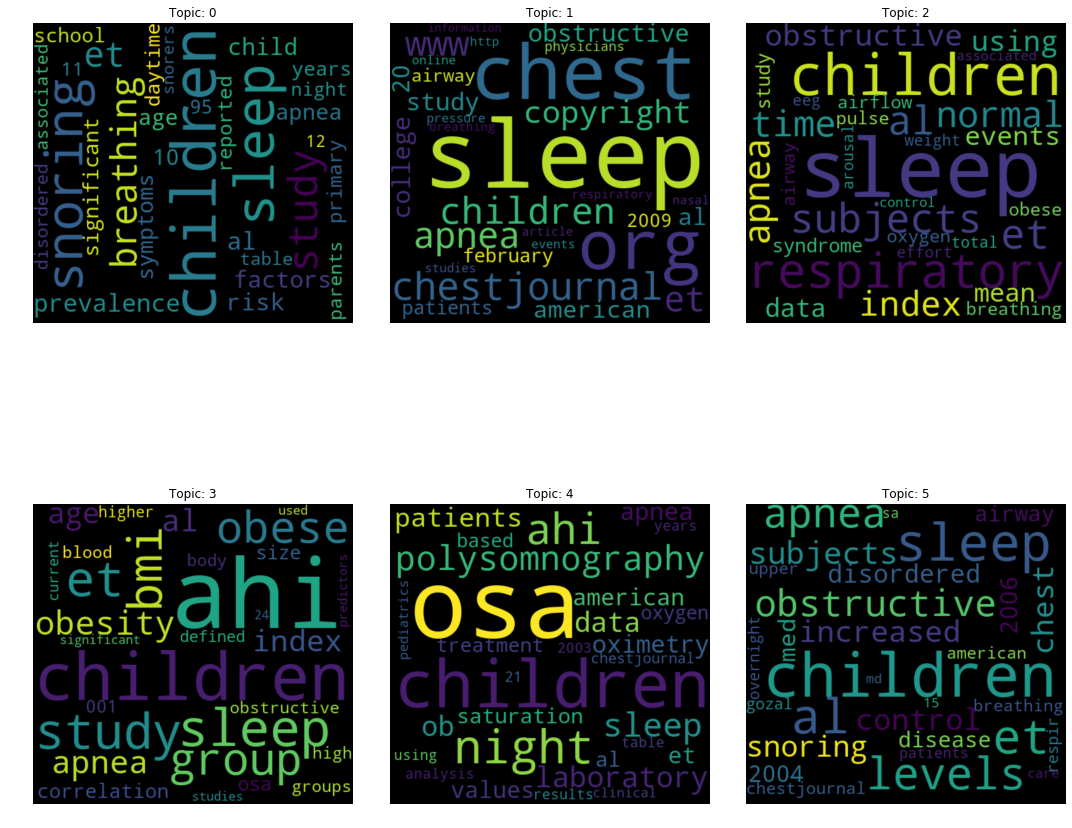

In [127]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

# create a 2 * 3 subplots of wordcloud to visualize the keyword
f, axarr = plt.subplots(2, 3, figsize=(15, 15));

for topic_idx, topic in enumerate(lda.components_):
    # create a dataframe with two columns (word, weight) for each topic
    
    # create a word:count dictionary
    f={tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:num_top_words]}
    
    # generate wordcloud in subplots
    wordcloud = WordCloud(width=480, height=450, margin=0, background_color="black");
    _ = wordcloud.generate_from_frequencies(frequencies=f);

    _ = axarr[math.floor(topic_idx/3), topic_idx%3].imshow(wordcloud, interpolation="bilinear");
    _ = axarr[math.floor(topic_idx/3), topic_idx%3].set_title("Topic: "+str(topic_idx));
    _ = axarr[math.floor(topic_idx/3), topic_idx%3].axis('off')

    
plt.tight_layout()
plt.show()